# RESCUE
*Renewable Energy Salient Combined Uncertainty Estimator*

A machine-learning based framework to quantify the short-term uncertainty in netload forecast developed by E3.

Characteristics includes:
1. Weather, time and recent errors aware.
2. Correlation aware as solar,wind, and load errors are co-trained.
3. Produces multiple prediction intervals for expected error in netload forecasting
4. Model agnostic. No requirement on knowledge of the inner workings of the netload forecast

Authors: Yuchi Sun, Vignesh Venugopal, Charles Gulian, Huai Jiang


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cross_val

# 1. Data Ingress

Load in net load forecast error data. Preprocessing of the data is handled by a separate package.

TODO: Standardize the output for stability
TODO: Add in the coverage percentage metric
TODO: Visualization for model performance in different regimes.
TODO: Identify unfinished business.

TODO: Proper CV

TODO: Basic Data check and Assertion

Use `tf.data` to batch and shuffle the dataset:

In [2]:
PI_percentiles = np.array([0.25,0.5,0.75])
model_directory = os.path.join(os.path.dirname(os.getcwd()),'trained_models','rescue_v1_0')

batch_size = 32
max_epochs = 20
optimizer_choice = 'adam'

In [3]:
# Read in input and output of the training and validation samples from data pipeline
input_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_inputs.pkl')).T
output_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_output.pkl')).T
n_samples = input_trainval.shape[0]



datetimes_trainval = pd.read_pickle(os.path.join('outputs_from_code','trainval_datetimes.pkl'))
num_cv_folds = 10
path_to_shuffled_indices = os.path.join("outputs_from_code","day_block_shuffled_indices.npy")

# Call function
val_masks_all_folds = cross_val.get_CV_masks(datetimes_trainval, num_cv_folds, path_to_shuffled_indices)

Day block shuffling pre-determnined....
Done....
Creating train val masks for each fold....
Creating training and validation sets for fold 1 of 10
Creating training and validation sets for fold 2 of 10
Creating training and validation sets for fold 3 of 10
Creating training and validation sets for fold 4 of 10
Creating training and validation sets for fold 5 of 10
Creating training and validation sets for fold 6 of 10
Creating training and validation sets for fold 7 of 10
Creating training and validation sets for fold 8 of 10
Creating training and validation sets for fold 9 of 10
Creating training and validation sets for fold 10 of 10
Train and val masks are ready!


## 2. Model Definition
Define the stucture of the model from start to finish. Includes normalization layer, ANN model and pinball loss.

In [4]:
# class two_layer_ANN(tf.keras.Model):
#     '''
#     A two-layer ANN model with a pinball loss to produce prediction interval.
#     The model can take an arbitrary amounts of input. As a rule of thumb less than 100 input terms would be preferred.
#     The model's target/label should be the true value of the prediction whose upper/lower bound we are interested in. 
#     In our application, since we are interested in the range of forecast erros, the label should be the forecast error.
    
#     '''
#     def __init__(self):
#         super(two_layer_ANN, self).__init__()
#         self.d1 = tf.keras.layers.Dense(10, activation='relu')
#         self.d2 = tf.keras.layers.Dense(10, activation='relu')
#         self.d3 = tf.keras.layers.Dense(1)

#     def call(self, x):
#         x = self.d1(x)
#         x = self.d2(x)
#         x = self.d3(x)
#         return x

Build the ANN model with Pinball loss using the Keras [functional API](https://www.tensorflow.org/guide/keras#model_subclassing)
                                                                    

In [5]:
# Create a model that include the normalization layer
inputs = tf.keras.Input(shape=input_trainval.shape[1:])

# Create a Normalization layer and set its internal state using the training data
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
norm_inputs = normalizer(inputs)

# A two-layer ANN network for regression
dense1 = tf.keras.layers.Dense(10, activation='relu')
hidden1 = dense1(norm_inputs)
dense2 = tf.keras.layers.Dense(10, activation='relu')
hidden2 = dense2(hidden1)
dense3 = tf.keras.layers.Dense(1)
outputs = dense3(hidden2)

# define model from inputs to outputs
rescue_model = tf.keras.Model(inputs, outputs)

In [6]:
class PinballLoss(tf.keras.losses.Loss):
    def __init__(self, tau=0.5, name="pinball_loss"):
        super().__init__(name=name)
        self.tau = tau

    def call(self, y_true, y_pred):
        err = y_true - y_pred
        skewed_mse = tf.math.reduce_mean(tf.math.maximum(self.tau * err, (self.tau - 1) * err), axis=0)

        return skewed_mse


class CoverageProbability(tf.keras.metrics.Metric):
    def __init__(self, name = 'CP',**kwargs):
        super(CoverageProbability, self).__init__(name = name, **kwargs)
        self.coverage_probability = self.add_weight(name = 'CP_Var', initializer="zeros", dtype = tf.float64)
        self.cum_n_samples = self.add_weight(name = 'n_samples', initializer="zeros", dtype = tf.int32)
        self.cum_n_covered = self.add_weight(name = 'n_covered', initializer="zeros", dtype = tf.int32)
        
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        # the state would be updated everytime we have a new calculation
        self.cum_n_samples.assign_add(tf.size(y_pred, out_type=tf.int32))
        self.cum_n_covered.assign_add(tf.math.count_nonzero(tf.math.less_equal(y_true,y_pred), dtype = tf.int32))
        self.coverage_probability.assign(tf.math.divide(self.cum_n_covered, self.cum_n_samples))

    def result(self):
        return self.coverage_probability

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.coverage_probability.assign(0.0)
    

# early stopping criteria is validation loss. 
# Min loss change of 1 in 2 epochs (patience)
cb_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1, patience=2 , verbose=1)

# we will overwrite the current checkpoint if and only if the `val_loss` score has improved.
# The saved model name will include the current epoch. and into the model_directory folder
def get_cb_check_points_for_tau(model_directory, tau):
    # make sure models for different tau go to different directories
    ckpt_directory = os.path.join(model_directory, "tau={:.0%}".format(tau))
    if not os.path.exists(ckpt_directory):
        os.makedirs(ckpt_directory)
    cb_check_points = tf.keras.callbacks.ModelCheckpoint(filepath=ckpt_directory, save_best_only=True, monitor="val_loss", verbose=0)
    return cb_check_points




In [8]:
rescue_model_set = {}
history = {}

for tau in PI_percentiles:
    print("Training model for Prediction interval: {:.0%}".format(tau))
    for fold_idx in range(num_cv_folds):
        print("Cross Validation fold #", fold_idx+1)
        
        # Split into training and validation dataset based on the validation masks of this CV fold
        input_train, output_train = input_trainval[~val_masks_all_folds[fold_idx]], output_trainval[~val_masks_all_folds[fold_idx]]
        input_val, output_val = input_trainval[val_masks_all_folds[fold_idx]], output_trainval[val_masks_all_folds[fold_idx]]
        
        # cast to 'float32'
        input_train = input_train.values.astype('float32')
        output_train = output_train.values.astype('float32')
        input_val = input_val.values.astype('float32')
        output_val = output_val.values.astype('float32')

        # Transoform into tensorflow Dataset type for training
        train_ds = tf.data.Dataset.from_tensor_slices((input_train, output_train)).shuffle(buffer_size= n_samples).batch(batch_size)
        val_ds = tf.data.Dataset.from_tensor_slices((input_val, output_val)).shuffle(buffer_size = n_samples).batch(batch_size)


        rescue_model_set[(tau, fold_idx)] = tf.keras.models.clone_model(rescue_model)
        rescue_model_set[(tau, fold_idx)].get_layer(index = 1).adapt(input_trainval.values) 
        rescue_model_set[(tau, fold_idx)].compile(loss = PinballLoss(tau = tau), 
                                                  metrics= [CoverageProbability()],optimizer=optimizer_choice)
        
        history[(tau, fold_idx)]= rescue_model_set[(tau, fold_idx)].fit(train_ds, validation_data=val_ds, epochs=max_epochs,
                                                                        callbacks=[cb_early_stopping, get_cb_check_points_for_tau(model_directory, tau)])

Training model for Prediction interval: 125%
Cross Validation fold # 0
Train for 2846 steps, validate for 317 steps
Epoch 1/20
2836/2846 [============================>.] - ETA: 0s - loss: 150.4851 - CP: 0.2011WARNING:tensorflow:From C:\Users\yuchi\Anaconda3\envs\e3rescue\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\yuchi\PycharmProjects\RESCUE\trained_models\rescue_v1_0\tau=25%\assets
2846/2846 [==============================] - 5s 2ms/step - loss: 150.3153 - CP: 0.2013 - val_loss: 130.1183 - val_CP: 0.2045
Epoch 2/20
2846/2846 [==============================] - 5s 2ms/step - loss: 101.8355 - CP: 0.2231 - val_loss: 124.0058 - val_CP: 0.2239
Epoch 3/20
2846/2846 [=============

In [9]:
history[(tau, fold_idx)].history

{'loss': [243.54954406190032,
  111.90926016535548,
  104.68081952969828,
  99.54629930150168,
  95.92892325912797,
  93.96498120493723,
  92.9786174573855,
  92.3652197542698,
  91.8674992554282,
  91.45429218174863],
 'CP': [0.5448685568708409,
  0.6485687980816744,
  0.6833040254092886,
  0.701579490194389,
  0.7136016909839735,
  0.7213994850843648,
  0.7266778004400036,
  0.7309013074193011,
  0.7340124768751402,
  0.7362196038657085],
 'val_loss': [124.01210484068477,
  112.09957353850645,
  106.02191310124442,
  101.45545918557922,
  98.51594106632076,
  97.4064562222935,
  96.45658436483389,
  95.66236481531185,
  95.47660773484864,
  94.90475296598127],
 'val_CP': [0.5617038098532391,
  0.6524040124524386,
  0.6851246067434238,
  0.7030982853189702,
  0.7142224638039235,
  0.7215957569468465,
  0.7271193499883523,
  0.7311829816672432,
  0.734008663998287,
  0.7364036171369274]}

In [23]:
# Visualizing cross-validation performance and generalizability of the model
# reassemble the best performing model's loss
train_losses = pd.DataFrame(None, index = PI_percentiles)
val_losses = train_losses.copy()
train_cp = train_losses.copy()
val_cp = train_losses.copy()

for tau in PI_percentiles:
    for fold_idx in range(num_cv_folds):
        train_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['loss'][-1]
        train_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['CP'][-1]
        val_losses.loc[tau, fold_idx] = history[(tau, fold_idx)].history['val_loss'][-1]
        val_cp.loc[tau,fold_idx] = history[(tau, fold_idx)].history['val_CP'][-1]

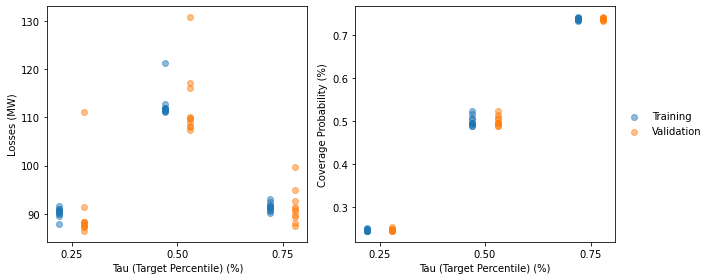

In [62]:
# Visualization of the training process

fig, axarr = plt.subplots(1,2, sharex = True)
train_x_pos =np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,10)) - 0.03
val_x_pos = np.expand_dims(np.array(PI_percentiles),1)*np.ones((1,10)) + 0.03

axarr[0].scatter(train_x_pos.ravel(), train_losses.values.ravel(),label = 'Training', alpha = 0.5)
axarr[0].scatter(val_x_pos.ravel(), val_losses.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[0].set_xticks(PI_percentiles)
axarr[0].set_xlabel('Tau (Target Percentile) (%)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].scatter(train_x_pos.ravel(), train_cp.values.ravel(), label = 'Training' ,alpha = 0.5)
axarr[1].scatter(val_x_pos.ravel(), val_cp.values.ravel(), label = 'Validation',alpha = 0.5)
axarr[1].set_xticks(PI_percentiles)
axarr[1].set_xlabel('Tau (Target Percentile) (%)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('cross_validation_and_generalizability.png', bbox_inches = 'tight')

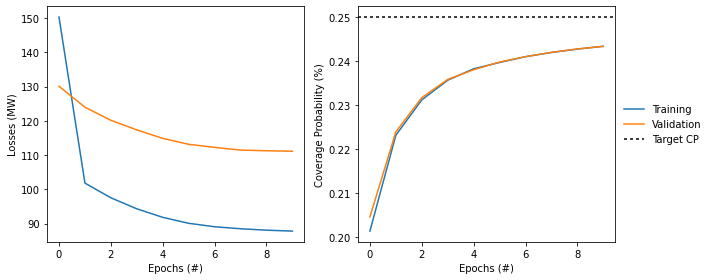

In [63]:
fig, axarr = plt.subplots(1,2, sharex = True)
history_eg = history[(0.25,0)].history

axarr[0].plot(history_eg['loss'],label = 'Training')
axarr[0].plot(history_eg['val_loss'], label = 'Validation')

axarr[0].set_xlabel('Epochs (#)')
axarr[0].set_ylabel('Losses (MW)')

axarr[1].plot(history_eg['CP'], label = 'Training')
axarr[1].plot(history_eg['val_CP'], label = 'Validation')
axarr[1].axhline(0.25, label = 'Target CP', dashes = [2,2], color = 'k')
axarr[1].set_xlabel('Epochs (#)')
axarr[1].set_ylabel('Coverage Probability (%)')

axarr[1].legend(loc = 'center left', bbox_to_anchor = [1,0.5], frameon = False)
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('training_history.png', bbox_inches = 'tight')

In [65]:
# Visualizing forecast uncertainty over different times of the day
low_band_forecast = rescue_model_set[(0.25,0)].predict(input_trainval.values)
median_forecast = rescue_model_set[(0.5,0)].predict(input_trainval.values)
high_band_forecast = rescue_model_set[(0.75,0)].predict(input_trainval.values)

prediction_timeseries['low'] = np.squeeze(low_band_forecast)
prediction_timeseries['median'] = np.squeeze(median_forecast)
prediction_timeseries['high'] = np.squeeze(high_band_forecast)

In [74]:
prediction_timeseries = pd.DataFrame(index = pd.to_datetime(datetimes_trainval.loc['T+1'], infer_datetime_format=True))

<AxesSubplot:xlabel='T+1'>

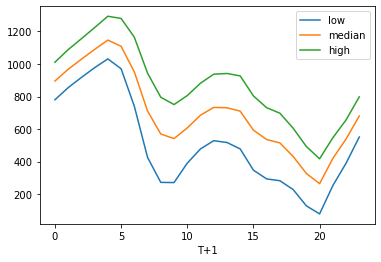

In [81]:
diurnal_trend = prediction_timeseries.groupby(prediction_timeseries.index.hour).mean()

diurnal_trend.plot()

<AxesSubplot:xlabel='T+1'>

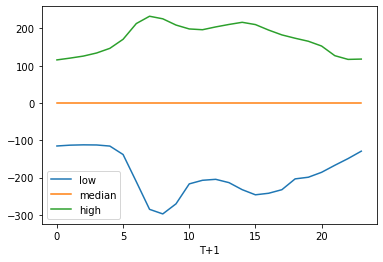

In [89]:
diurnal_trend_debiased = diurnal_trend - np.expand_dims(diurnal_trend['median'].values, axis=1)
diurnal_trend_debiased.plot()

In [72]:
datetimes_trainval

,0,1,2,3,4,5,6,7,8,9,...,101175,101176,101177,101178,101179,101180,101181,101182,101183,101184
T-2,1/1/2017 0:00,1/1/2017 0:15,1/1/2017 0:30,1/1/2017 0:45,1/1/2017 1:00,1/1/2017 1:15,1/1/2017 1:30,1/1/2017 1:45,1/1/2017 2:00,1/1/2017 2:15,...,12/31/2019 20:45,12/31/2019 21:00,12/31/2019 21:15,12/31/2019 21:30,12/31/2019 21:45,12/31/2019 22:00,12/31/2019 22:15,12/31/2019 22:30,12/31/2019 22:45,12/31/2019 23:00
T-1,1/1/2017 0:15,1/1/2017 0:30,1/1/2017 0:45,1/1/2017 1:00,1/1/2017 1:15,1/1/2017 1:30,1/1/2017 1:45,1/1/2017 2:00,1/1/2017 2:15,1/1/2017 2:30,...,12/31/2019 21:00,12/31/2019 21:15,12/31/2019 21:30,12/31/2019 21:45,12/31/2019 22:00,12/31/2019 22:15,12/31/2019 22:30,12/31/2019 22:45,12/31/2019 23:00,12/31/2019 23:15
T0,1/1/2017 0:30,1/1/2017 0:45,1/1/2017 1:00,1/1/2017 1:15,1/1/2017 1:30,1/1/2017 1:45,1/1/2017 2:00,1/1/2017 2:15,1/1/2017 2:30,1/1/2017 2:45,...,12/31/2019 21:15,12/31/2019 21:30,12/31/2019 21:45,12/31/2019 22:00,12/31/2019 22:15,12/31/2019 22:30,12/31/2019 22:45,12/31/2019 23:00,12/31/2019 23:15,12/31/2019 23:30
T+1,1/1/2017 0:45,1/1/2017 1:00,1/1/2017 1:15,1/1/2017 1:30,1/1/2017 1:45,1/1/2017 2:00,1/1/2017 2:15,1/1/2017 2:30,1/1/2017 2:45,1/1/2017 3:00,...,12/31/2019 21:30,12/31/2019 21:45,12/31/2019 22:00,12/31/2019 22:15,12/31/2019 22:30,12/31/2019 22:45,12/31/2019 23:00,12/31/2019 23:15,12/31/2019 23:30,12/31/2019 23:45


# 3. Deploying the model

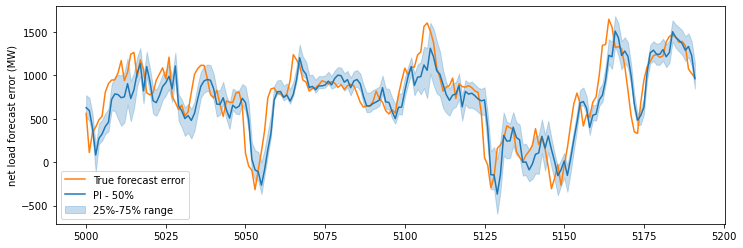

In [10]:
example_range = np.arange(5000,5192)
input_val_eg = input_val[example_range]
output_val_eg = output_val[example_range]

# confirm the PI percentiles are symmetrical
for PI in PI_percentiles:
    assert 1-PI in PI_percentiles, "Not all PI intervals are constructed symmetrically!"


fig,ax = plt.subplots()
ax.plot(example_range, output_val_eg, color = 'C1', label = 'True forecast error')

# plot median forecast if it is being produced
if 0.5 in PI_percentiles:
    ax.plot(example_range, rescue_model_set[0.5].predict(input_val_eg), color = 'C0', label = 'PI - 50%')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)),
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)),
                        color = 'C0', alpha = PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))

ax.set_ylabel("net load forecast error (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

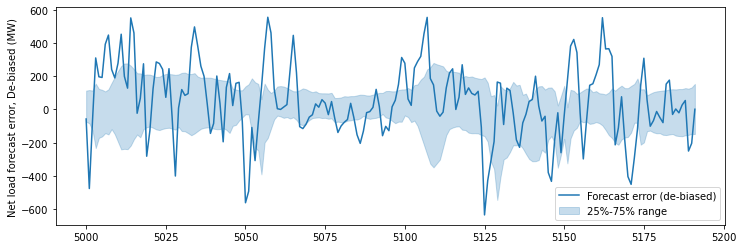

In [10]:
fig,ax = plt.subplots()
inherent_bias_eg = np.squeeze(rescue_model_set[0.5].predict(input_val[example_range]))

ax.plot(example_range, np.squeeze(output_val_eg) - inherent_bias_eg, label = 'Forecast error (de-biased)')

for PI in PI_percentiles:
    if PI<0.5:
        ax.fill_between(example_range, np.squeeze(rescue_model_set[PI].predict(input_val_eg)) - inherent_bias_eg,
                        np.squeeze(rescue_model_set[1-PI].predict(input_val_eg)) - inherent_bias_eg,
                        color = 'C0', alpha =PI, label = '{:.0%}-{:.0%} range'.format(PI, 1-PI))


ax.set_ylabel("Net load forecast error, De-biased (MW)")
ax.legend()
fig.set_size_inches(12,4)

plt.show()

Choose an optimizer and loss function for training: 

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [7]:
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# test_loss = tf.keras.metrics.Mean(name='test_loss')

Use `tf.GradientTape` to train the model:

Test the model:

In [9]:
@tf.function
def train_step(inputs, outputs, model, loss_fn):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(inputs, training=True)
        loss = loss_fn(outputs, predictions)
    gradients = tape.gradient(loss, rescue.trainable_variables)
    optimizer.apply_gradients(zip(gradients, rescue.trainable_variables))

    train_loss(loss)
    #train_accuracy(outputs, predictions)


@tf.function
def test_step(inputs, outputs, model, loss_fn):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = rescue(inputs, training=False)
    t_loss = loss_object(outputs, predictions)

    test_loss(t_loss)
    #test_accuracy(outputs, predictions)

In [10]:
# EPOCHS = 5

# for epoch in range(EPOCHS):
#   # Reset the metrics at the start of the next epoch
#   train_loss.reset_states()
#   #train_accuracy.reset_states()
#   test_loss.reset_states()
#   #test_accuracy.reset_states()

#   for inputs, outputs in train_ds:
#     train_step(inputs, outputs)

#   for test_inputs, test_outputs in test_ds:
#     test_step(test_inputs, test_outputs)

#   print(
#     f'Epoch {epoch + 1}, '
#     f'Loss: {train_loss.result()}, '
#     #f'Accuracy: {train_accuracy.result() * 100}, '
#     f'Test Loss: {test_loss.result()}, '
#     #f'Test Accuracy: {test_accuracy.result() * 100}'
#   )

Epoch 1, Loss: nan, Test Loss: nan, 
Epoch 2, Loss: nan, Test Loss: nan, 
Epoch 3, Loss: nan, Test Loss: nan, 
Epoch 4, Loss: nan, Test Loss: nan, 
Epoch 5, Loss: nan, Test Loss: nan, 
